# SDE Formulation of Diffusion Models: Interactive Tutorial

This notebook implements the concepts from the companion theory document [`README.md`](./README.md).

**Learning objectives:**
1. Visualize Brownian motion and understand its properties
2. Simulate forward SDEs (data → noise)
3. Implement score matching training
4. Sample from reverse SDEs (noise → data)
5. Compare VP-SDE and VE-SDE

**Prerequisites:**
- Basic probability (Gaussian distributions)
- PyTorch fundamentals
- Understanding of DDPM (see `01_ddpm_basics.ipynb`)

---

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from pathlib import Path
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Add src to path for importing genailab
sys.path.insert(0, str(Path('../../../src').resolve()))

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

# Random seeds
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


## 1. Understanding Brownian Motion

Before diving into SDEs, let's visualize Brownian motion $w(t)$ and understand its key properties:

1. $w(0) = 0$
2. Independent increments
3. $w(t+\Delta t) - w(t) \sim \mathcal{N}(0, \Delta t)$
4. Continuous but nowhere differentiable

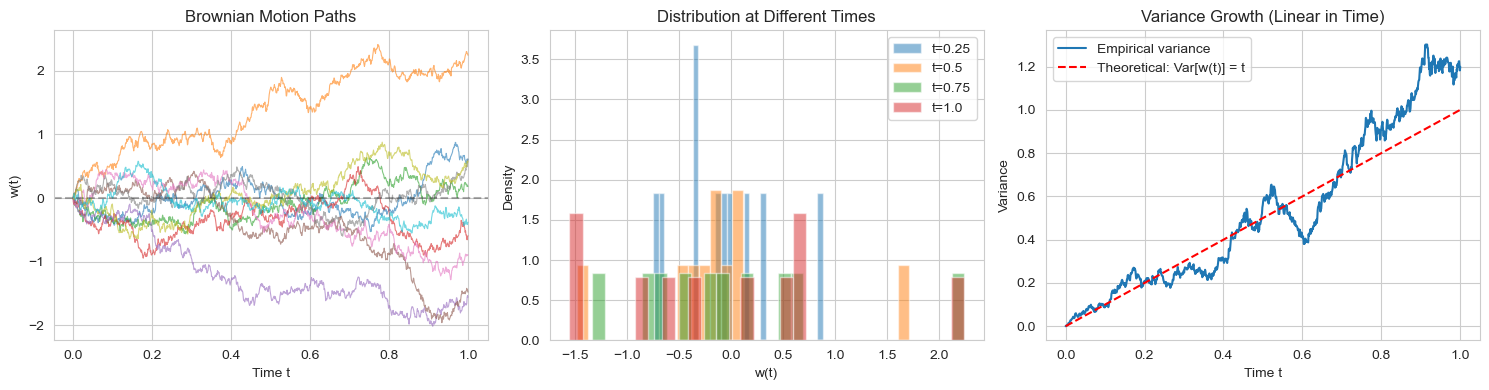

Key property: Variance at t=1.0 is 1.199 (should be ≈ 1.0)
Standard deviation scales as √t: std(w(0.25)) = 0.454 ≈ 0.500


In [2]:
def simulate_brownian_motion(T=1.0, num_steps=1000, num_paths=5):
    """Simulate Brownian motion paths.
    
    Args:
        T: Total time
        num_steps: Number of discrete steps
        num_paths: Number of paths to simulate
    
    Returns:
        t: Time points
        w: Brownian motion paths [num_paths, num_steps]
    """
    dt = T / num_steps
    t = np.linspace(0, T, num_steps)
    
    # Generate increments: dw ~ N(0, dt)
    dw = np.random.randn(num_paths, num_steps) * np.sqrt(dt)
    
    # Cumulative sum to get w(t)
    w = np.cumsum(dw, axis=1)
    
    # Ensure w(0) = 0
    w = np.concatenate([np.zeros((num_paths, 1)), w], axis=1)
    t = np.concatenate([[0], t])
    
    return t, w

# Simulate and visualize
t, w = simulate_brownian_motion(T=1.0, num_steps=1000, num_paths=10)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Multiple paths
for i in range(10):
    axes[0].plot(t, w[i], alpha=0.6, linewidth=0.8)
axes[0].set_xlabel('Time t')
axes[0].set_ylabel('w(t)')
axes[0].set_title('Brownian Motion Paths')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 2: Distribution at different times
times = [0.25, 0.5, 0.75, 1.0]
for time in times:
    idx = int(time * 1000)
    axes[1].hist(w[:, idx], bins=30, alpha=0.5, label=f't={time}', density=True)
axes[1].set_xlabel('w(t)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution at Different Times')
axes[1].legend()

# Plot 3: Variance over time (should be linear)
variance = np.var(w, axis=0)
axes[2].plot(t, variance, label='Empirical variance')
axes[2].plot(t, t, 'r--', label='Theoretical: Var[w(t)] = t')
axes[2].set_xlabel('Time t')
axes[2].set_ylabel('Variance')
axes[2].set_title('Variance Growth (Linear in Time)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Key property: Variance at t=1.0 is {variance[-1]:.3f} (should be ≈ 1.0)")
print(f"Standard deviation scales as √t: std(w(0.25)) = {np.std(w[:, 250]):.3f} ≈ {np.sqrt(0.25):.3f}")

## 2. Forward SDE: Data → Noise

Let's implement the forward SDE that corrupts data:

$$
dx = f(x,t)\,dt + g(t)\,dw(t)
$$

We'll focus on **VP-SDE** (Variance-Preserving):

$$
dx = -\frac{1}{2}\beta(t) x\,dt + \sqrt{\beta(t)}\,dw(t)
$$

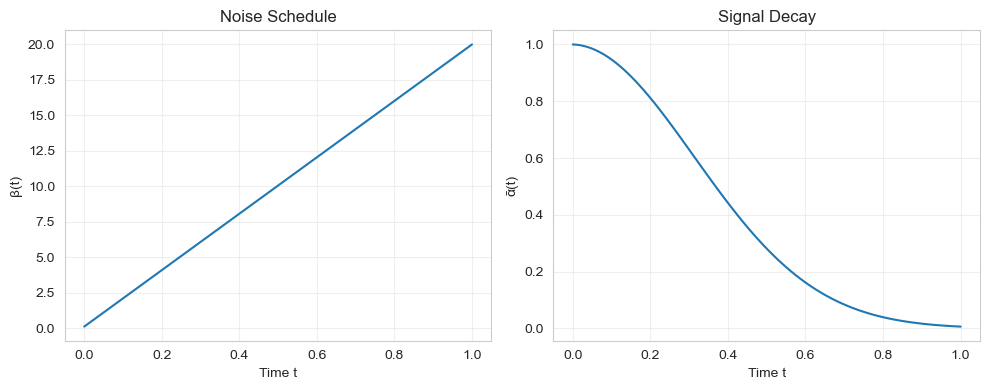

In [3]:
class VPSDE:
    """Variance-Preserving SDE."""
    
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        """
        Args:
            beta_min: Minimum noise level
            beta_max: Maximum noise level
            T: Total diffusion time
        """
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
    
    def beta(self, t):
        """Linear noise schedule."""
        return self.beta_min + (self.beta_max - self.beta_min) * t / self.T
    
    def drift(self, x, t):
        """Drift coefficient: f(x,t) = -0.5 * beta(t) * x"""
        return -0.5 * self.beta(t) * x
    
    def diffusion(self, t):
        """Diffusion coefficient: g(t) = sqrt(beta(t))"""
        return np.sqrt(self.beta(t))
    
    def marginal_prob(self, x0, t):
        """Compute mean and std of p_t(x | x_0).
        
        For VP-SDE:
        mean = sqrt(alpha_bar_t) * x_0
        std = sqrt(1 - alpha_bar_t)
        """
        # Compute alpha_bar_t = exp(-0.5 * integral_0^t beta(s) ds)
        log_alpha_bar = -0.25 * t**2 * (self.beta_max - self.beta_min) / self.T - 0.5 * t * self.beta_min
        alpha_bar = np.exp(log_alpha_bar)
        
        # Reshape alpha_bar for proper broadcasting with x0
        # Only reshape when x0 is 2D AND t is an array (batch case)
        if x0.ndim > 1 and np.ndim(t) > 0:
            alpha_bar = alpha_bar.reshape(-1, 1)
        
        mean = np.sqrt(alpha_bar) * x0
        std = np.sqrt(1 - alpha_bar)
        
        return mean, std
    
    def sample_from_marginal(self, x0, t):
        """Sample x_t ~ p_t(x | x_0)."""
        mean, std = self.marginal_prob(x0, t)
        noise = np.random.randn(*x0.shape)
        return mean + std * noise, noise

# Test the SDE
sde = VPSDE(beta_min=0.1, beta_max=20.0, T=1.0)

# Visualize beta(t)
t_vals = np.linspace(0, 1, 100)
beta_vals = [sde.beta(t) for t in t_vals]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t_vals, beta_vals)
plt.xlabel('Time t')
plt.ylabel('β(t)')
plt.title('Noise Schedule')
plt.grid(True, alpha=0.3)

# Visualize alpha_bar(t)
alpha_bar_vals = [np.exp(-0.25 * t**2 * (sde.beta_max - sde.beta_min) - 0.5 * t * sde.beta_min) for t in t_vals]
plt.subplot(1, 2, 2)
plt.plot(t_vals, alpha_bar_vals)
plt.xlabel('Time t')
plt.ylabel('ᾱ(t)')
plt.title('Signal Decay')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualize Forward Diffusion on 2D Data

Let's see how the SDE corrupts a simple 2D distribution (Swiss roll).

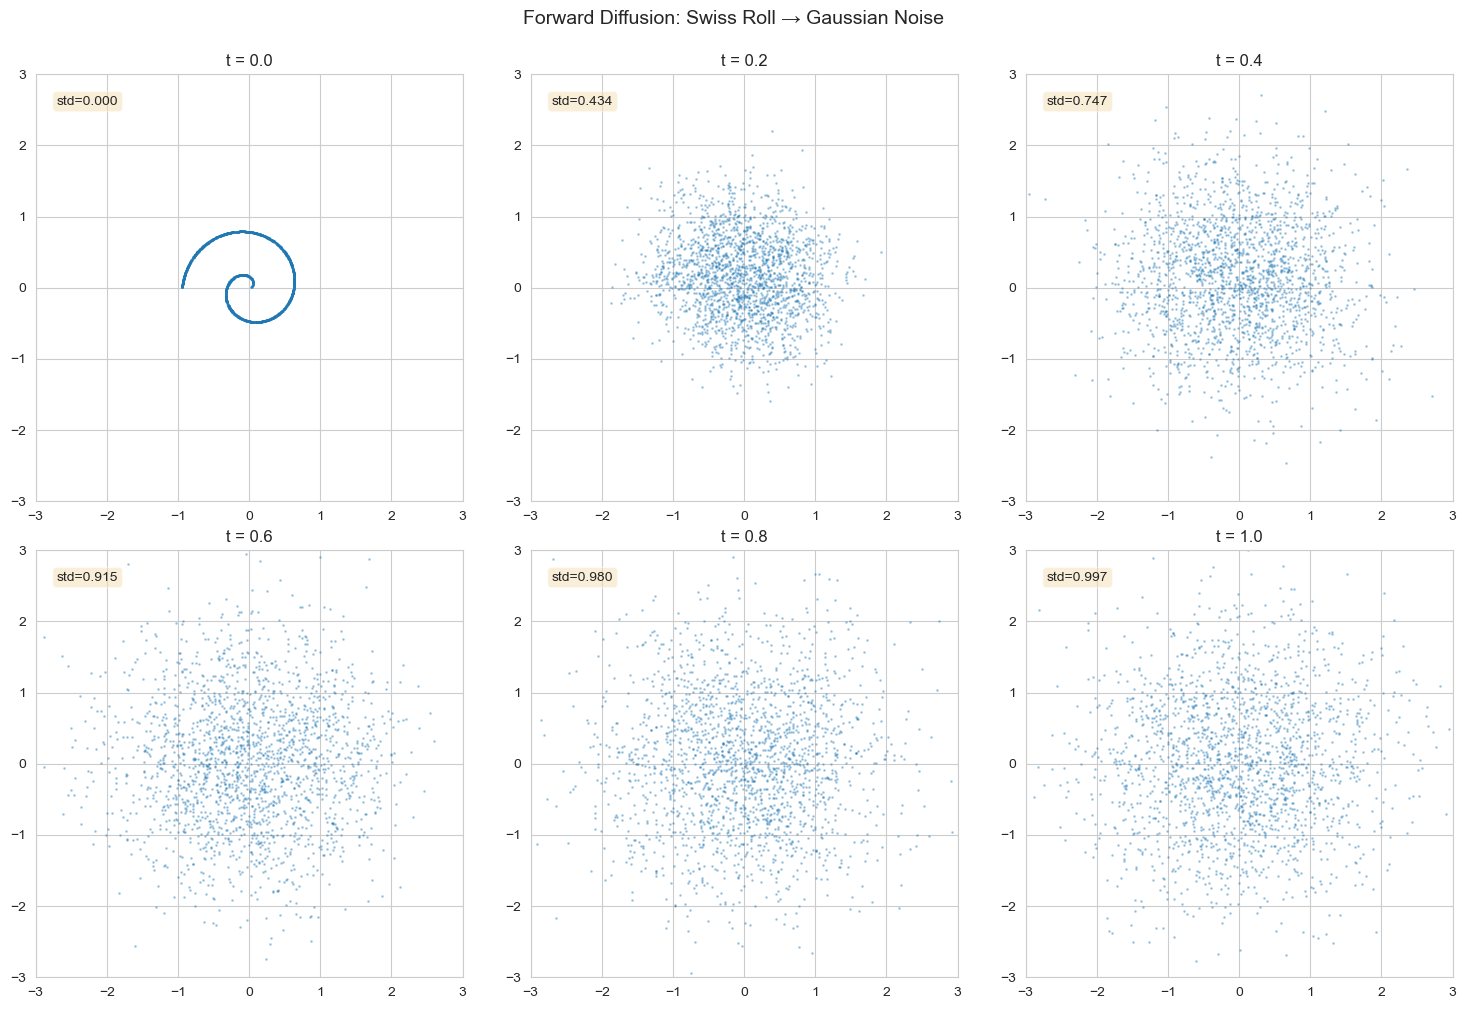

Observation: As t increases, the structure dissolves into isotropic Gaussian noise.


In [4]:
def generate_swiss_roll(n_samples=1000):
    """Generate 2D Swiss roll dataset."""
    theta = np.sqrt(np.random.rand(n_samples)) * 3 * np.pi
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)
    data = np.stack([x, y], axis=1) / 10.0  # Scale down
    return data

# Generate data
x0 = generate_swiss_roll(n_samples=2000)

# Apply forward diffusion at different times
times = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, t in enumerate(times):
    if t == 0:
        xt = x0
    else:
        xt, _ = sde.sample_from_marginal(x0, t)
    
    axes[i].scatter(xt[:, 0], xt[:, 1], alpha=0.3, s=1)
    axes[i].set_xlim(-3, 3)
    axes[i].set_ylim(-3, 3)
    axes[i].set_title(f't = {t:.1f}')
    axes[i].set_aspect('equal')
    
    # Show mean and std
    mean, std = sde.marginal_prob(x0, t)
    axes[i].text(0.05, 0.95, f'std={std:.3f}', 
                transform=axes[i].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Forward Diffusion: Swiss Roll → Gaussian Noise', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("Observation: As t increases, the structure dissolves into isotropic Gaussian noise.")

## 3. Score Function and Training

The **score function** is the gradient of the log-density:

$$
s(x, t) = \nabla_x \log p_t(x)
$$

For training, we use **denoising score matching**. The conditional score has a closed form:

$$
\nabla_x \log p_t(x_t | x_0) = -\frac{x_t - \text{mean}(t)}{\text{std}^2(t)} = -\frac{\varepsilon}{\text{std}(t)}
$$

where $\varepsilon$ is the noise we added.

In [5]:
class SimpleScoreNetwork(nn.Module):
    """Simple MLP score network for 2D data."""
    
    def __init__(self, data_dim=2, hidden_dim=128, time_dim=32):
        super().__init__()
        
        # Time embedding (sinusoidal)
        self.time_dim = time_dim
        
        # Network
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim),
        )
    
    def time_embedding(self, t):
        """Sinusoidal time embedding."""
        half_dim = self.time_dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb
    
    def forward(self, x, t):
        """Predict score: s(x, t) ≈ ∇_x log p_t(x).
        
        Args:
            x: Data [batch_size, data_dim]
            t: Time [batch_size]
        
        Returns:
            score: [batch_size, data_dim]
        """
        t_emb = self.time_embedding(t)
        h = torch.cat([x, t_emb], dim=-1)
        return self.net(h)

# Test the network
model = SimpleScoreNetwork(data_dim=2, hidden_dim=128).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
x_test = torch.randn(16, 2).to(device)
t_test = torch.rand(16).to(device)
score_test = model(x_test, t_test)
print(f"Input shape: {x_test.shape}")
print(f"Output shape: {score_test.shape}")

Model parameters: 37,762
Input shape: torch.Size([16, 2])
Output shape: torch.Size([16, 2])


### Training Loop

Train the score network using denoising score matching:

$$
\mathcal{L}(\theta) = \mathbb{E}_{t, x_0, \varepsilon} \left[ \lambda(t) \left\| s_\theta(x_t, t) + \frac{\varepsilon}{\sigma(t)} \right\|^2 \right]
$$

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 500/2000, Loss: 32.2674
Epoch 1000/2000, Loss: 130.8129
Epoch 1500/2000, Loss: 113.7178
Epoch 2000/2000, Loss: 19.3626


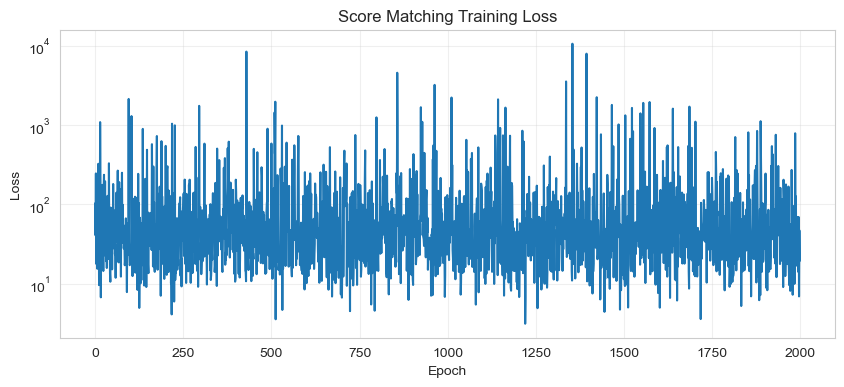

Final loss: 19.362591


In [ ]:
# Use the improved implementation from src/genailab/diffusion
from genailab.diffusion import VPSDE as VPSDE_Module
from genailab.diffusion import SimpleScoreNetwork as ScoreNet
from genailab.diffusion import train_score_network, sample_reverse_sde

# Re-initialize with the improved module implementations
sde = VPSDE_Module(beta_min=0.1, beta_max=20.0, T=1.0)
model = ScoreNet(data_dim=2, hidden_dim=256).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the model with the improved training function
losses = train_score_network(
    model=model,
    data=x0,
    sde=sde,
    num_epochs=5000,
    batch_size=128,
    lr=1e-3,
    device=device,
)

# Plot training curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Score Matching Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.6f}")

## 4. Sampling: Reverse SDE

Generate samples by solving the reverse-time SDE:

$$
dx = \left[f(x,t) - g(t)^2 s_\theta(x,t)\right] dt + g(t)\,d\bar{w}(t)
$$

We'll use the **Euler-Maruyama method** to discretize this.

In [ ]:
# Generate samples using the module's sampling function
samples, trajectory = sample_reverse_sde(
    model=model,
    sde=sde,
    n_samples=2000,
    num_steps=500,
    data_dim=2,
    device=device,
)

print(f"Generated {samples.shape[0]} samples")
print(f"Trajectory has {len(trajectory)} snapshots")

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Generated 2000 samples
Trajectory has 11 snapshots


### Visualize Generated Samples

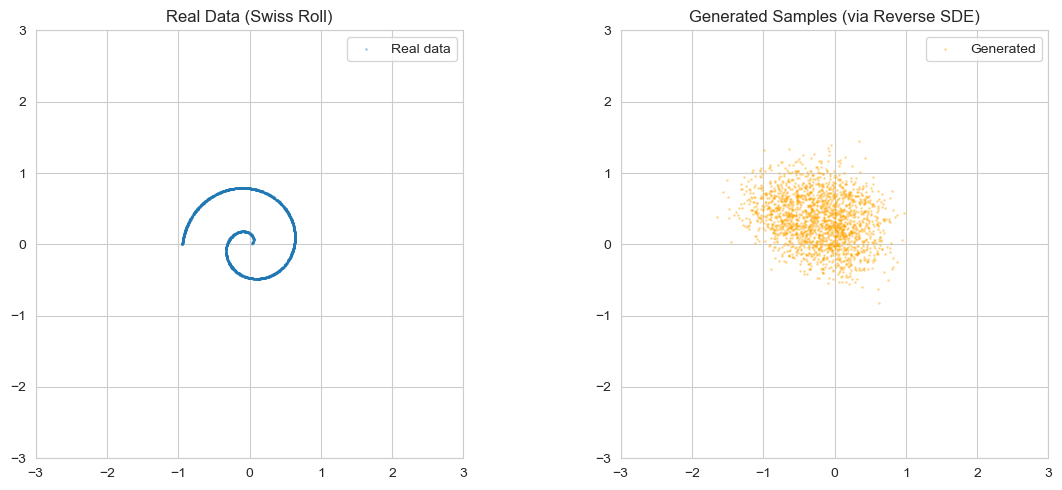

In [8]:
# Compare real vs generated
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(x0[:, 0], x0[:, 1], alpha=0.3, s=1, label='Real data')
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)
axes[0].set_title('Real Data (Swiss Roll)')
axes[0].set_aspect('equal')
axes[0].legend()

axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1, label='Generated', color='orange')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].set_title('Generated Samples (via Reverse SDE)')
axes[1].set_aspect('equal')
axes[1].legend()

plt.tight_layout()
plt.show()

### Visualize Reverse Diffusion Process

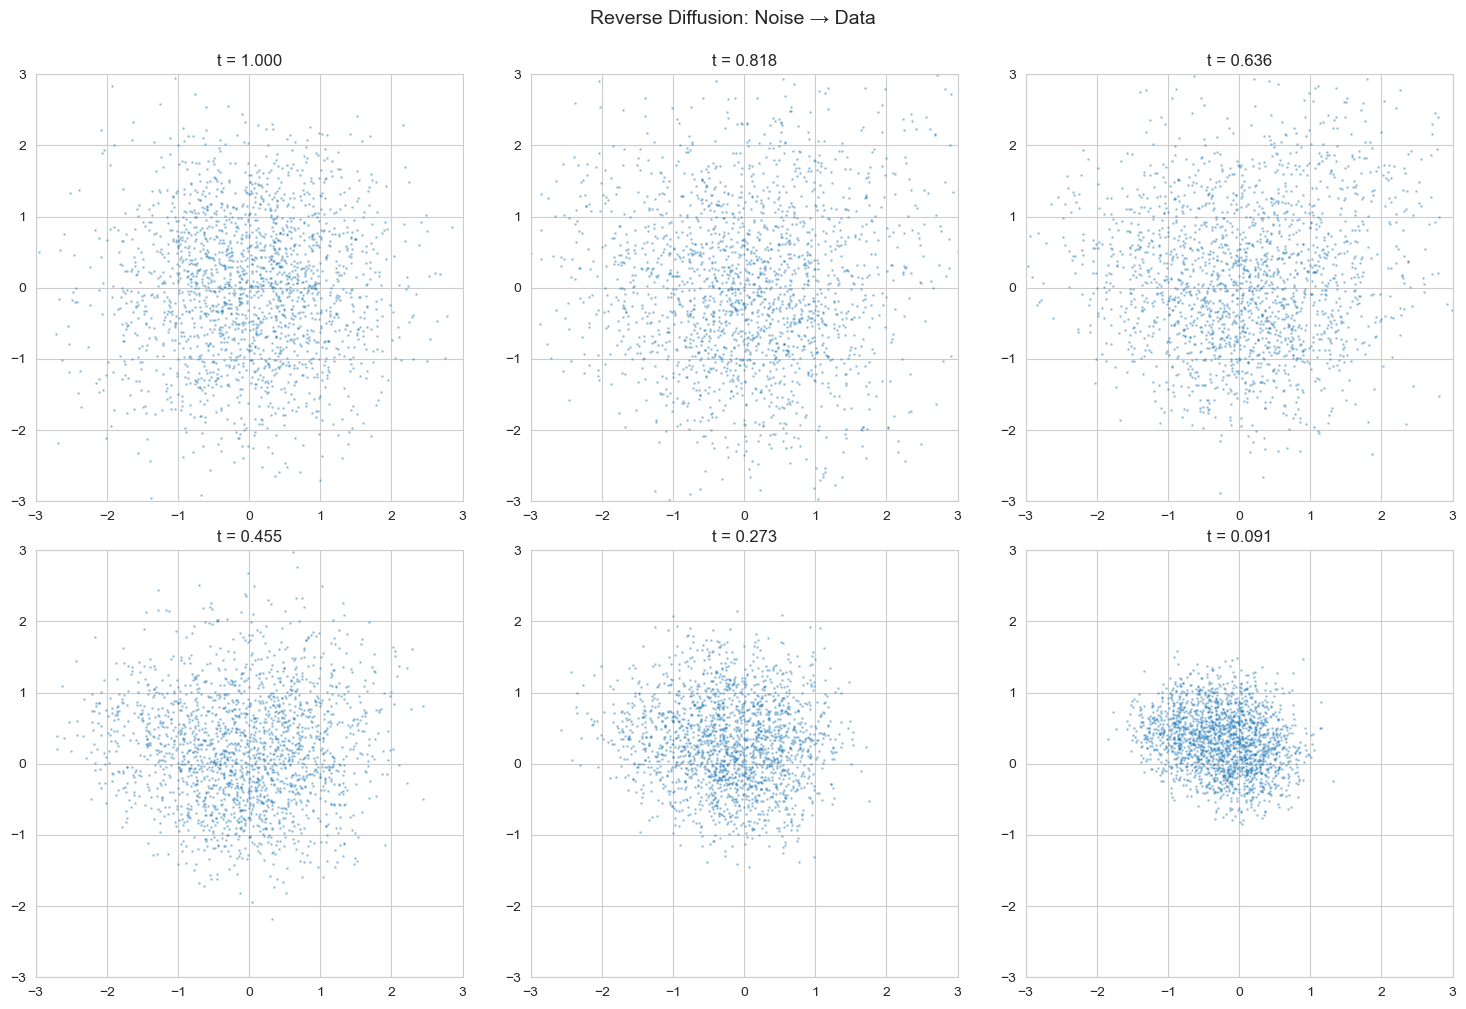

In [9]:
# Show snapshots of reverse process
num_snapshots = min(6, len(trajectory))
indices = np.linspace(0, len(trajectory)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(indices):
    xt = trajectory[idx]
    t_val = sde.T * (1 - idx / len(trajectory))
    
    axes[i].scatter(xt[:, 0], xt[:, 1], alpha=0.3, s=1)
    axes[i].set_xlim(-3, 3)
    axes[i].set_ylim(-3, 3)
    axes[i].set_title(f't = {t_val:.3f}')
    axes[i].set_aspect('equal')

plt.suptitle('Reverse Diffusion: Noise → Data', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 5. Probability Flow ODE (Deterministic Sampling)

Instead of the stochastic reverse SDE, we can use the **probability flow ODE**:

$$
\frac{dx}{dt} = f(x,t) - \frac{1}{2}g(t)^2 s_\theta(x,t)
$$

This generates samples **deterministically** (like DDIM).

ODE Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

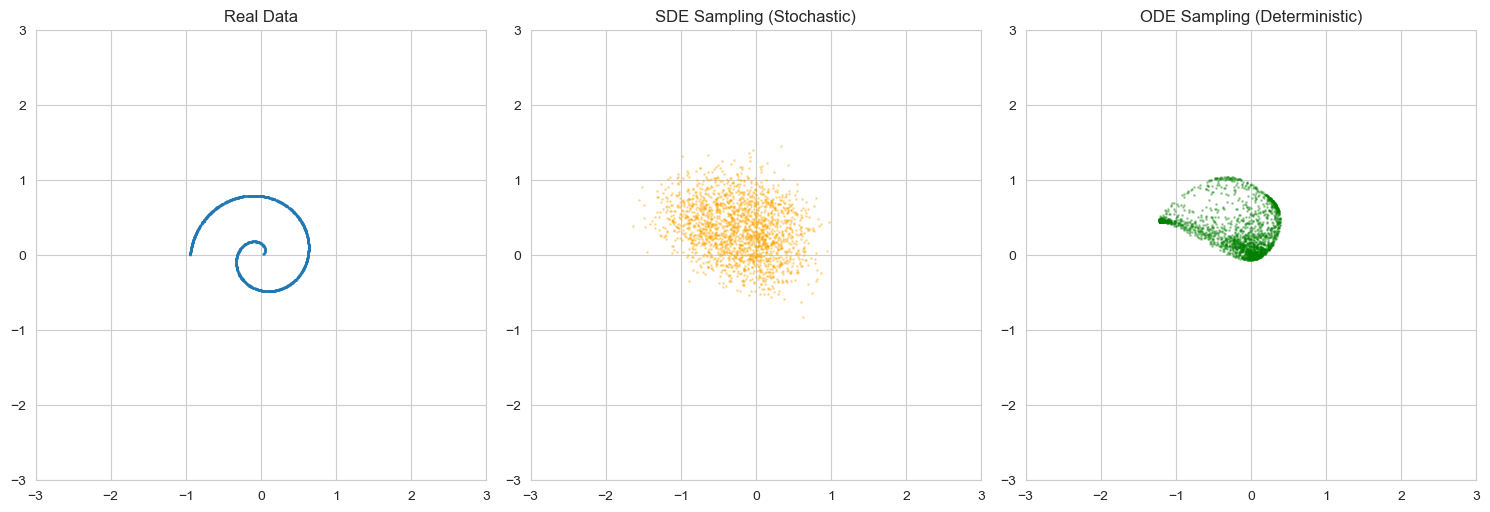

Note: ODE sampling is faster (fewer steps) but may be less diverse.


In [ ]:
from genailab.diffusion import sample_probability_flow_ode

# Generate samples with ODE
samples_ode = sample_probability_flow_ode(
    model=model,
    sde=sde,
    n_samples=2000,
    num_steps=100,
    data_dim=2,
    device=device,
)

# Compare SDE vs ODE sampling
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(x0[:, 0], x0[:, 1], alpha=0.3, s=1)
axes[0].set_title('Real Data')
axes[0].set_aspect('equal')

axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.3, s=1, color='orange')
axes[1].set_title('SDE Sampling (Stochastic)')
axes[1].set_aspect('equal')

axes[2].scatter(samples_ode[:, 0], samples_ode[:, 1], alpha=0.3, s=1, color='green')
axes[2].set_title('ODE Sampling (Deterministic)')
axes[2].set_aspect('equal')

for ax in axes:
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

print("Note: ODE sampling is faster (fewer steps) but may be less diverse.")

## Summary

We've implemented the SDE framework for diffusion models:

1. ✅ **Brownian motion**: Visualized continuous random walks
2. ✅ **Forward SDE**: Corrupted data with VP-SDE
3. ✅ **Score matching**: Trained neural network to predict scores
4. ✅ **Reverse SDE**: Generated samples by solving reverse-time SDE
5. ✅ **Probability flow ODE**: Deterministic sampling alternative

**Key takeaways:**
- SDEs provide a **continuous-time** view of diffusion
- Only the **score function** needs to be learned
- **Reverse SDE** (stochastic) vs **ODE** (deterministic) sampling
- VP-SDE is the continuous version of DDPM

**Next steps:**
- Apply to high-dimensional data (images, gene expression)
- Implement conditional generation
- Study scPPDM (latent-space VP-SDE for drug response)

See [`README.md`](./README.md) for detailed theory and mathematical derivations.